In [8]:
train_path = './train/train'
all_paths = os.listdir(train_path)
cat_paths = [path for path in all_paths if path.startswith('cat')]
dog_paths = [path for path in all_paths if path.startswith('dog')]

train_paths = cat_paths[2500:] + dog_paths[2500:]
val_paths = cat_paths[:2500] + dog_paths[:2500]

In [9]:
random.seed(42)
random.shuffle(train_paths)
random.shuffle(val_paths)

In [10]:
print(len(all_paths))
print(len(cat_paths))
print(len(dog_paths))

25000
12500
12500


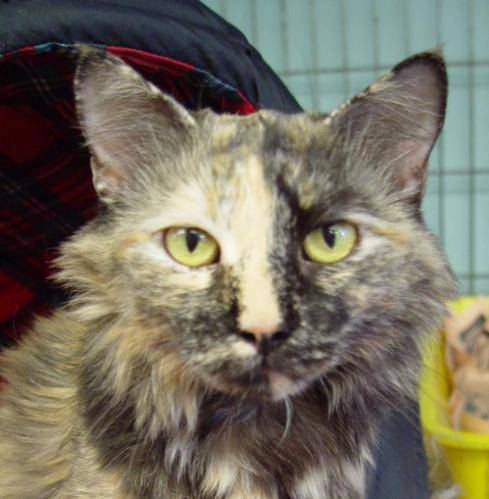

In [11]:
example_with_cat = os.path.join(train_path , cat_paths[2])
Image.open(example_with_cat)

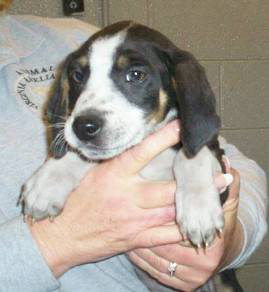

In [12]:
ex_with_dog = os.path.join(train_path , dog_paths[2])
Image.open(ex_with_dog)

In [13]:
train_transform = v2.Compose(
[
  v2.PILToTensor(),
  v2.RandomHorizontalFlip(p = 0.5),
  v2.RandomVerticalFlip(p = 0.5),  
  v2.RandomResizedCrop(size = [227, 227], antialias = True),  
  v2.ToDtype(torch.float32, scale = True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # for resnet
]
)

val_transform = v2.Compose(
[
  v2.PILToTensor(),
  v2.ToDtype(torch.float32, scale = True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])  # for resnet
  
]
)

transform = {
    "train_transform": train_transform,
    "val_transform": val_transform
}

In [14]:
class dataset(Dataset):
    def __init__(self, paths, transform = None, is_train = True) :
        self.paths = paths
        self.transform = transform
        self.is_train = is_train
        
    
    def __getitem__(self, index):
        full_path = os.path.join(train_path, self.paths[index])
        img = Image.open(full_path)
        img = img.resize((227, 227))
        label = self.paths[index][:3]
        
        if self.transform:
            if self.is_train:
                img = self.transform["train_transform"](img)
            else:
                img = self.transform["val_transform"](img)
            
        
        return img, int(label == "cat")
    
    def __len__(self):
        return len(self.paths)

In [15]:
train_data = dataset(train_paths, transform)
val_data = dataset(val_paths, transform, is_train = False)

In [16]:
train_data[2][0].shape

torch.Size([3, 227, 227])

In [17]:
train_loader = DataLoader(train_data , shuffle = True , batch_size= 32)
val_loader = DataLoader(val_data , shuffle = True , batch_size= 32)

In [18]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 227, 227])

In [19]:
next(iter(train_loader))[1]

tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


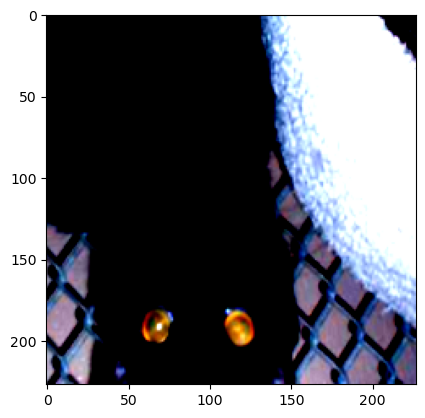

In [20]:
img = train_data[0][0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import zipfile
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [22]:
image_dir = "./train/train/"
filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]
data = pd.DataFrame({"filename": filenames, "label": labels})
data.head()

filename label
0     cat.0.jpg   cat
1     cat.1.jpg   cat
2    cat.10.jpg   cat
3   cat.100.jpg   cat
4  cat.1000.jpg   cat

In [23]:
data['label'].value_counts()

label
cat    12500
dog    12500
Name: count, dtype: int64

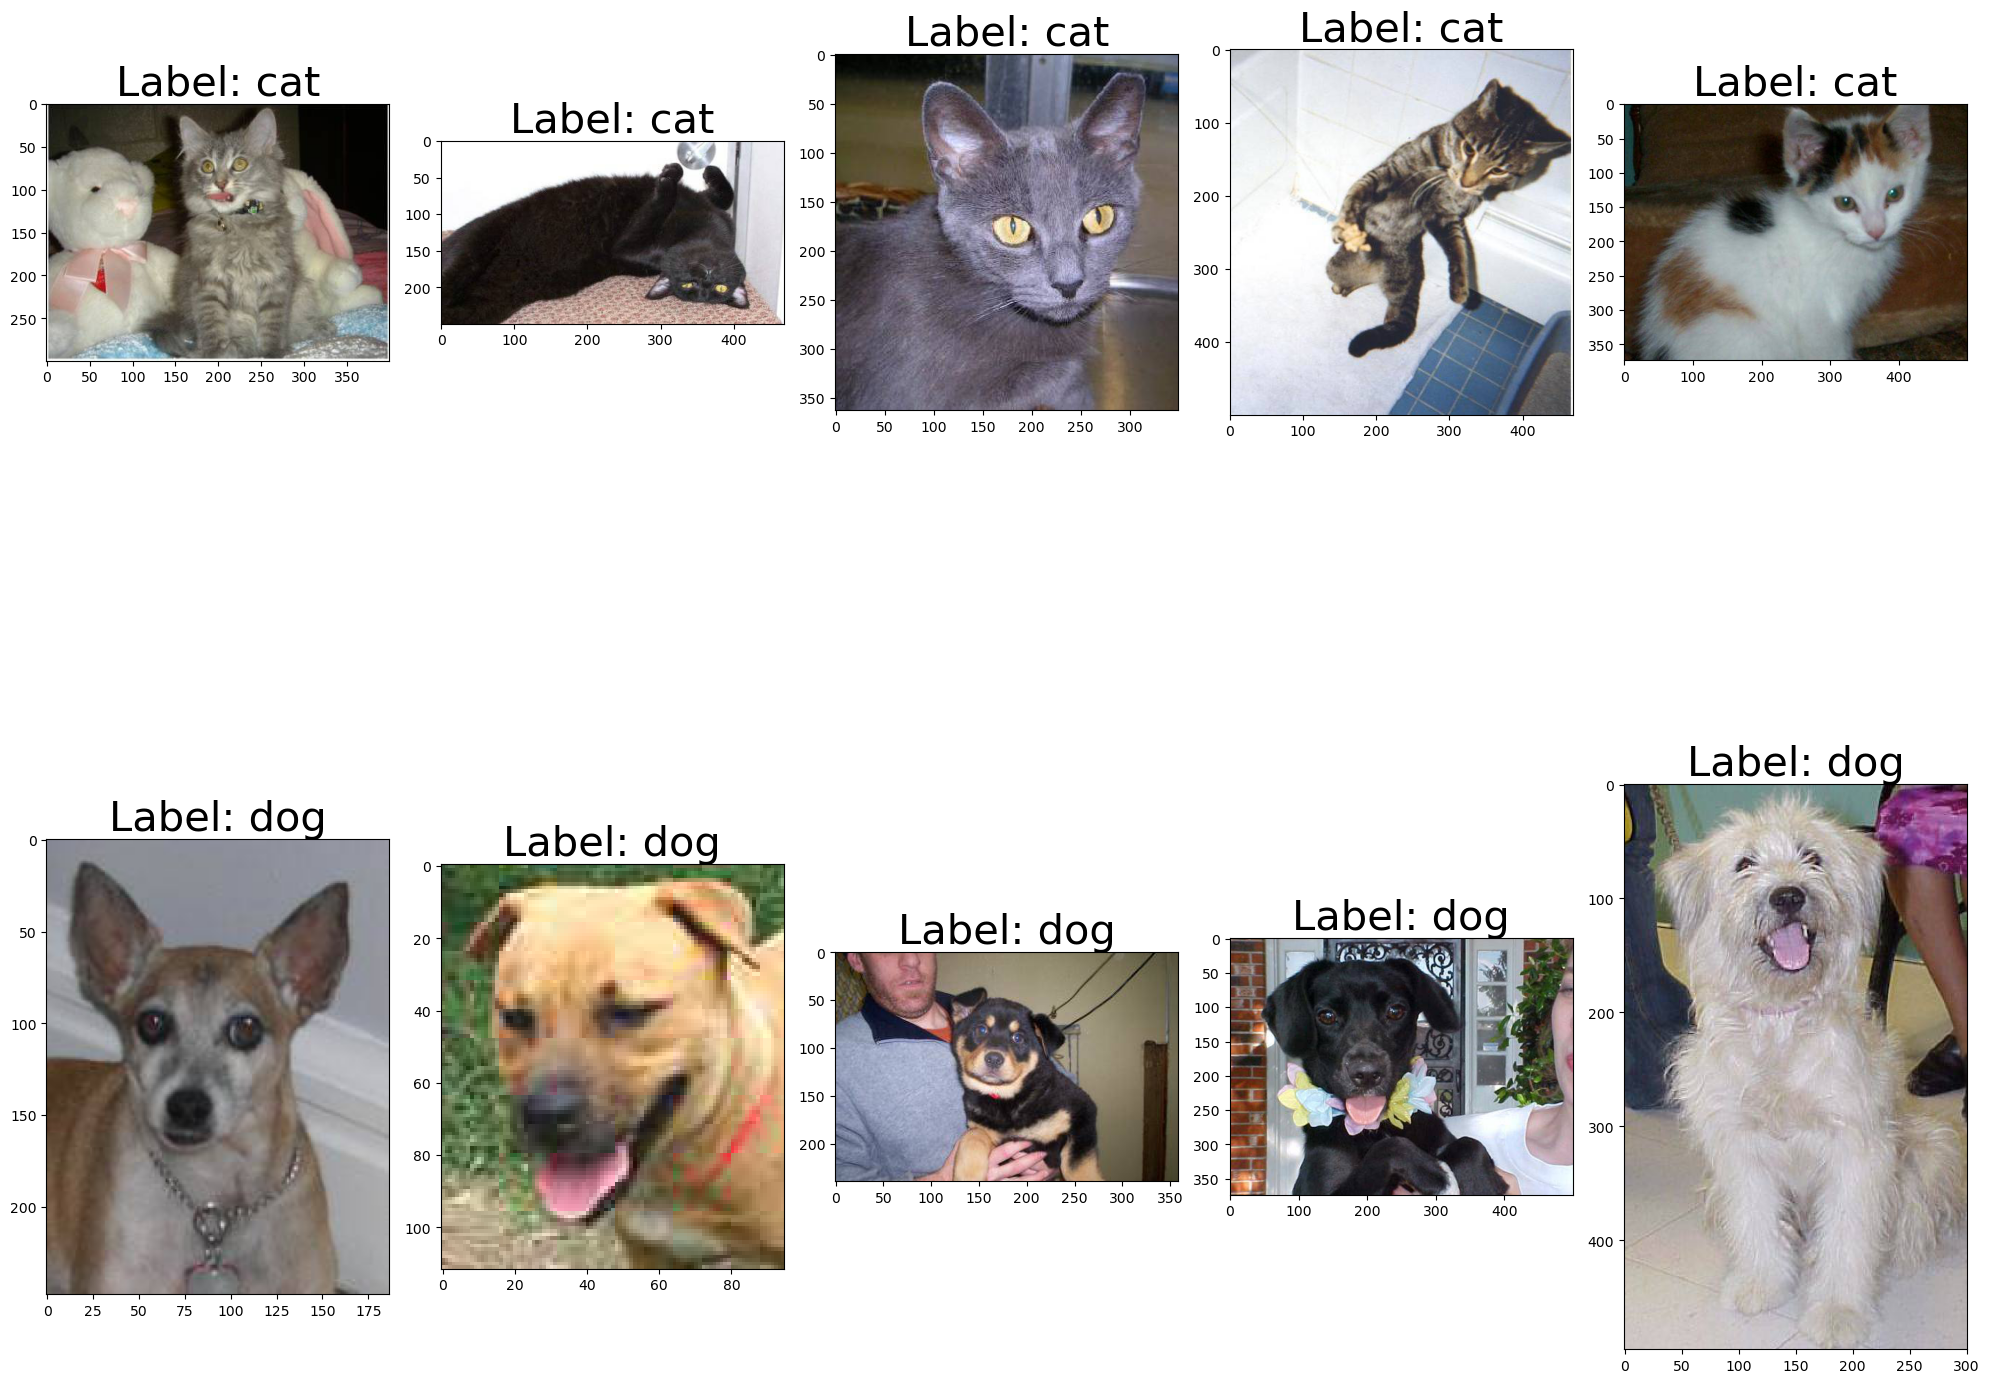

In [24]:
grouped_data = data.groupby("label")

num_images_per_category = 5

fig, axes = plt.subplots(len(grouped_data), num_images_per_category, figsize=(20, 20))

for i, (category, group) in enumerate(grouped_data):
  
    random_indices = random.sample(range(len(group)), num_images_per_category)

    for j, index in enumerate(random_indices):
        filename = group.iloc[index]["filename"]
        label = group.iloc[index]["label"]
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        axes[i, j].imshow(image)
        axes[i, j].set_title("Label: " + label, fontsize = 30)
        

plt.tight_layout()
plt.show()

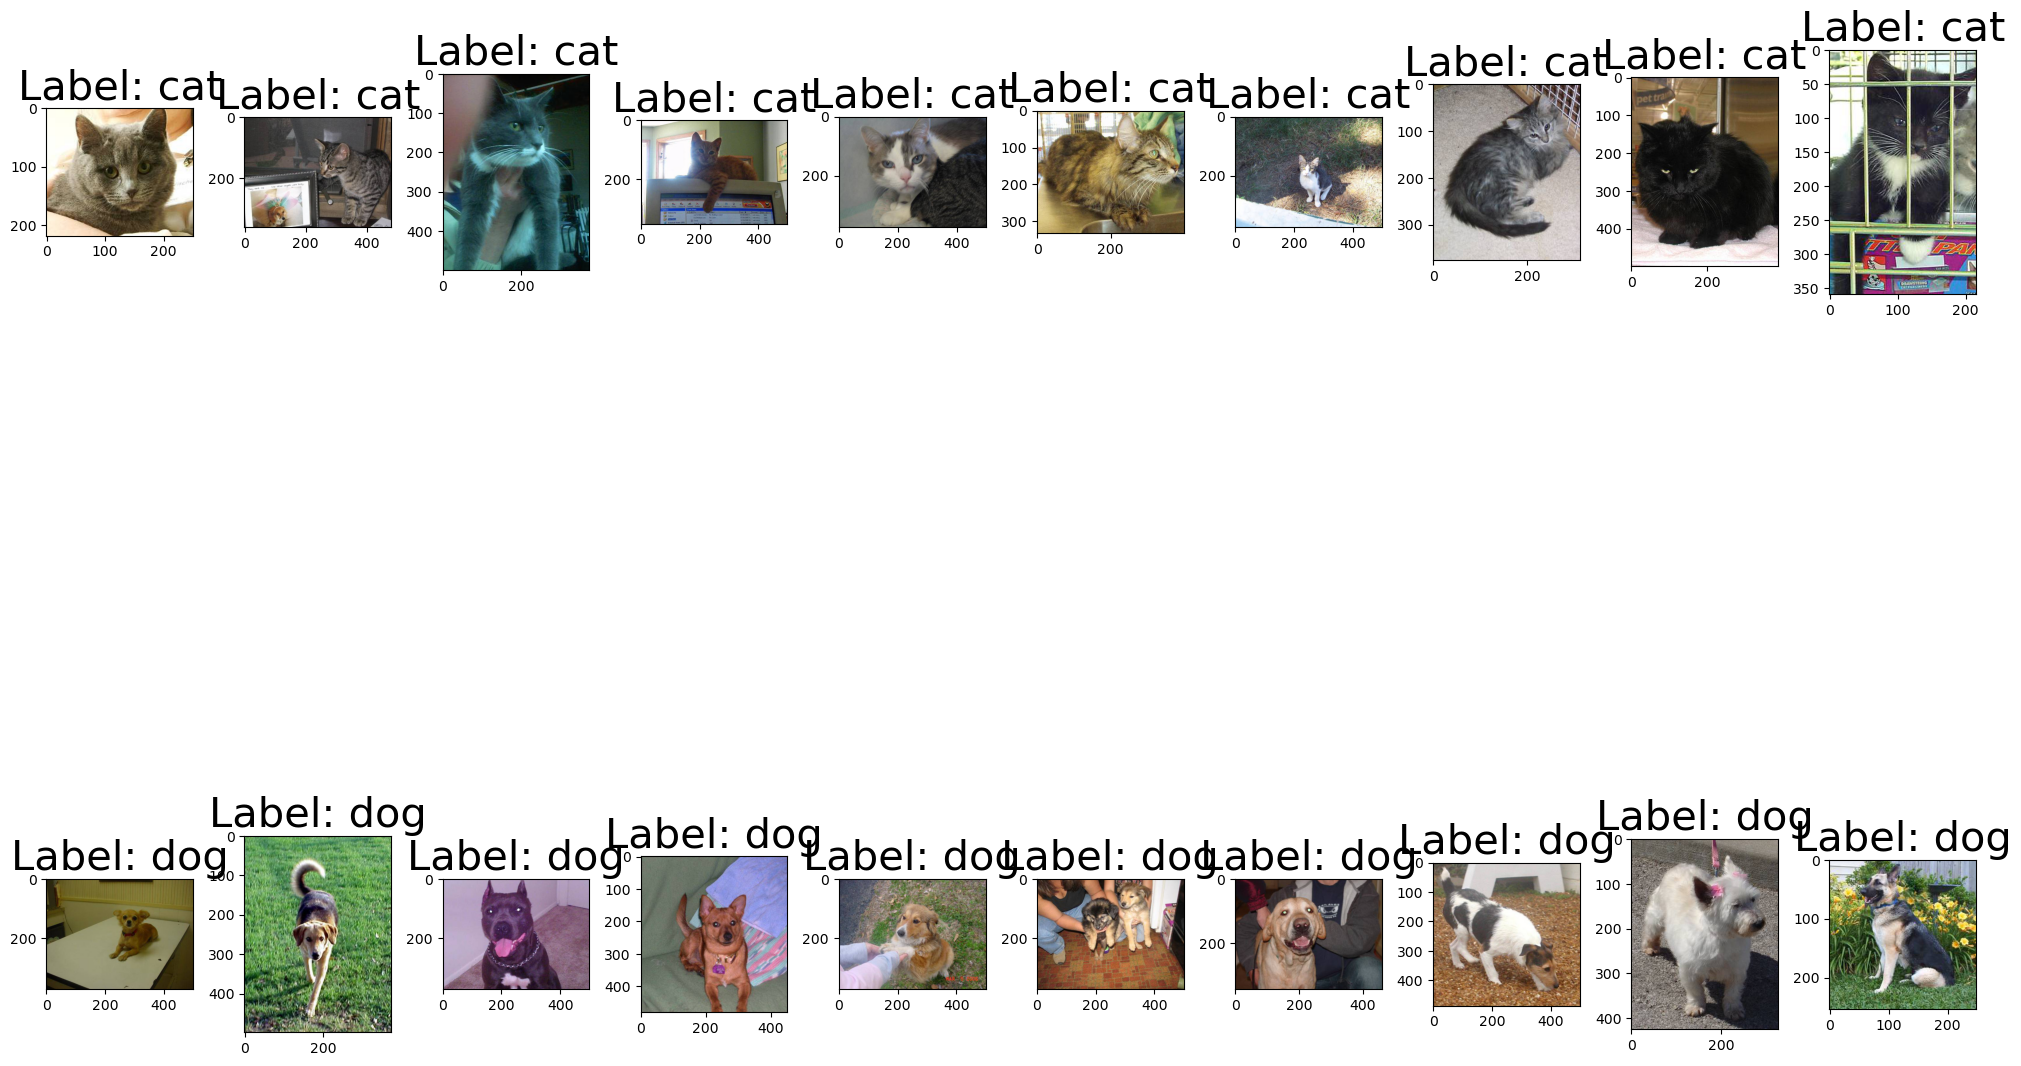

In [25]:
grouped_data = data.groupby("label")

num_images_per_category = 10

fig, axes = plt.subplots(len(grouped_data), num_images_per_category, figsize=(20, 20))

for i, (category, group) in enumerate(grouped_data):
  
    random_indices = random.sample(range(len(group)), num_images_per_category)

    for j, index in enumerate(random_indices):
        filename = group.iloc[index]["filename"]
        label = group.iloc[index]["label"]
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)

        axes[i, j].imshow(image)
        axes[i, j].set_title("Label: " + label, fontsize = 30)
        

plt.tight_layout()
plt.show()

In [26]:
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

image_width = []
image_height = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)

median_width = np.median(image_width)
median_height = np.median(image_height)


print('median_size:', median_width,  'X', median_height)

median_size: 447.0 X 374.0


In [27]:
labels = data['label']
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 23)

label_test_val = X_temp['label']
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 23)

print ('X_train:', X_train['label'].value_counts())

print ('X_val:', X_val['label'].value_counts())

print ('X_test:', X_test['label'].value_counts())

X_train: label
cat    10000
dog    10000
Name: count, dtype: int64
X_val: label
cat    1250
dog    1250
Name: count, dtype: int64
X_test: label
dog    1250
cat    1250
Name: count, dtype: int64


In [28]:
batch_size = 64
size = (370, 370)
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

In [51]:
train_idg = idg.flow_from_dataframe(X_train, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\81807\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 20000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [52]:
val_idg = idg.flow_from_dataframe(X_val, "train/", x_col="filename", y_col="label",
                                  batch_size = batch_size,
                                  target_size = size, shuffle = False)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\81807\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2500 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [53]:
test_idg = idg.flow_from_dataframe(X_test, "train/", x_col= "filename", y_col= "label",
                                    batch_size = batch_size,
                                    target_size=size, shuffle = False)

Found 0 validated image filenames belonging to 0 classes.


c:\Users\81807\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 2500 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [32]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(370, 370, 3))

In [33]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 370, 370, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 370, 370, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 370, 370, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 185, 185, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 185, 185, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 185, 185, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 92, 92, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 92, 92, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 92, 92, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 92, 92, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 46, 46, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 46, 46, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 46, 46, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 23, 23, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 23, 23, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 23, 23, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 23, 23, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
for layer in vgg16_model.layers:
  layer.trainable = False

In [35]:
flat = tf.keras.layers.Flatten() (vgg16_model.output)
dropout1 = tf.keras.layers.Dropout(0.2, name="Dropout1") (flat)
dense1 = tf.keras.layers.Dense(128, activation="relu") (dropout1)
dropout2 = tf.keras.layers.Dropout(0.2, name="Dropout2")(dense1)
output = tf.keras.layers.Dense(2, activation="softmax") (dropout2)

final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output])

In [36]:
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [37]:
from tensorflow.keras.utils import plot_model

In [38]:
final_model.compile(optimizer='adam',
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [39]:
final_model.compile(optimizer='adam',
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [55]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint("DogCat.keras",
                                                monitor="val_loss",
                                                save_best_only=True)

In [41]:
x = np.random.random((1000, 32))

In [42]:
y = np.random.random((1000, 1))

In [50]:
history = final_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs = 10, callbacks=[model_ckpt])

ValueError: Must provide at least one structure